In [56]:
import os
import glob
import cv2
import shutil
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
from skimage.io import imread
from tensorflow import keras
from sklearn.model_selection import train_test_split

# Creating Dataframe

## Variables

In [42]:
# Directories
# dataDir = './data'
dataDir = '.\data'
# Dataframe
df = pd.DataFrame(data={
    "bird":[],"cat":[],"dog":[],"path":[]
    })
df['bird'] = df['bird'].astype(np.int8)
df['cat']  = df['cat'].astype(np.int8)
df['dog']  = df['dog'].astype(np.int8)
df['path'] = df['path'].astype(np.str0)

animals = ['cat','dog','bird']

## Filling Dataframe

In [43]:
for animal in animals:
    for dirname,_,filenames in os.walk(os.path.join(dataDir,animal)):
        for file in filenames:
            try:
                path = os.path.join(dataDir,animal,animal,file)
                df = pd.concat(
                    [ df,
                        pd.DataFrame({
                            'dog':  1 if animal == 'dog' else 0,
                            'cat':  1 if animal == 'cat' else 0,
                            'bird': 1 if animal == 'bird' else 0,
                            'path': [path]
                        })
                    ],
                    ignore_index=True
                )
            except:
                print("Issue at filename: ", file)

# Model Creation

### Train/Test Split

In [50]:
dataTrain, dataTest = train_test_split(
    df,
    train_size=0.05
)

### Variables

In [48]:
dirTrain = "trainData"
dirTest  = "testData"
dirValidation = "validationData"
root = "./output"

### Creating directories

In [59]:
def createDirectories(dir):
    os.makedirs(os.path.join(root,'dataset',dir))
    for animal in animals:   
        os.makedirs(os.path.join(root,'dataset',dir,animal))

In [60]:
# Create directories if they haven't already been created
if os.path.isdir(os.path.join(root,'dataset')) == False:
    os.makedirs(os.path.join(root,'dataset'))

# Training directories
if os.path.isdir(os.path.join(root,'dataset',dirTrain)) == False:
    createDirectories(dirTrain)
    
# Testing directories
if os.path.isdir(os.path.join(root,'dataset',dirTest)) == False:
    createDirectories(dirTest)

### Adding images to train/test folder

In [53]:
def folderPrep(row,dir):
    head, tail = os.path.split(row.path)
    if row.bird  == 1:
        newPath  = os.path.join(root,'dataset',dir,'bird',tail)
    elif row['cat'] == 1:
        newPath    = os.path.join(root,'dataset',dir,'cat',tail)
    elif row.dog == 1:
        newPath  = os.path.join(root,'dataset',dir,'dog',tail)
    shutil.copyfile(row.path,newPath)    
    return newPath

In [58]:
dataTrain['path'] = dataTrain.apply(folderPrep,axis=1,dir=dirTrain)

In [57]:
dataTest['path'] = dataTest.apply(folderPrep,axis=1,dir=dirTest)

### Training prep

In [62]:
BATCH_SIZE = 256
IMG_RES    = (227,227)

In [61]:
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [63]:
from keras.preprocessing.image import ImageDataGenerator

image_gen =  ImageDataGenerator(
        rescale= 1.0/255.0
        )
train = image_gen.flow_from_directory(
        os.path.join(root,'dataset',dirTrain), 
        class_mode='categorical',
        batch_size=BATCH_SIZE,
        target_size=IMG_RES
        )
validation = image_gen.flow_from_directory(
        os.path.join(root,'dataset',dirTest),
        class_mode='categorical',
        batch_size=BATCH_SIZE,
        target_size=IMG_RES
        )

Found 667 images belonging to 3 classes.
Found 12677 images belonging to 3 classes.


In [65]:
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense,Conv2D,MaxPool2D,Flatten,Dropout,BatchNormalization

In [77]:
model = Sequential()
model.add(
    Conv2D(
        filters=128,
        kernel_size=11,
        activation ='relu',
        strides=4,
        input_shape =(IMG_RES[0],IMG_RES[1],3)
    )
)
model.add(MaxPool2D(3,2))
model.add(Flatten())
model.add(Dense(128,activation = 'relu'))
model.add(Dense(3,activation = 'softmax'))  

In [ ]:
model.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
history = model.fit(train,epochs=50,validation_data=validation)

In [80]:
model.save('classification1L.h5')

# Testing

## AlexNet Model

In [81]:
from numpy.linalg import svd
alexModel = keras.models.load_model('image_classification.h5')

In [84]:
options = {
    0: 'bird',
    1: 'cat',
    2: 'dog'
}

### Testing Dataframe

In [89]:
testingDf = df.sample(n=100)
paths = testingDf['path'].values

## SVD Compression

In [121]:
svdTotalCorrect = 0
# svdConfidence = []
results = []

In [83]:
def truncateSVD(A, k):
    U, S, Vt = svd(A)
    Ak = np.dot(U[:,:k],np.dot(np.diag(S[:k]),Vt[:k,:]))
    return Ak

def compressImg(img,k):
#   Send img to matrix
    imgMatrix = np.array(list(img.getdata(band=0)))
    imgMatrix.shape = (img.size[1],img.size[0])
    imgMatrix = np.matrix(imgMatrix) 
#   Compress with SVD
    compressedMatrix = truncateSVD(imgMatrix,k)
#   Convert back to img
    compressedImg = Image.fromarray(compressedMatrix)
    return compressedImg

In [235]:
def predictAnimal(img,predModel):
    img = np.array(img).astype(np.float64)
    img = img.reshape(-1,227,227,3)
    img /= 255.
    prediction = predModel.predict(img)
    return prediction

In [87]:
def getResult(arr):
    x = np.argmax(arr)
    string = options[x]
    return string

In [88]:
def getAnimal(str):
    if 'cat' in str:
        return 'cat'
    elif 'dog' in str:
        return 'dog'
    elif 'bird' in str:
        return 'bird'

In [ ]:
for k in range(10,100,5):
    svdTotalCorrect = 0
    for path in paths:
        # Compress Image
        img  = Image.open(path).resize((227,227))
        imgC = compressImg(img,k).convert('RGB')
        # Make prediction
        prediction = getResult(predictAnimal(imgC,alexModel)[0])
        answer = getAnimal(path)
        # Evaluate prediction
        if prediction == answer:
            svdTotalCorrect += 1
    # Add result to result list
    results.append(svdTotalCorrect)

In [246]:
print(results)

[62, 72, 77, 78, 79, 81, 80, 80, 80, 80, 81, 80, 82, 81, 81, 81, 81, 81]


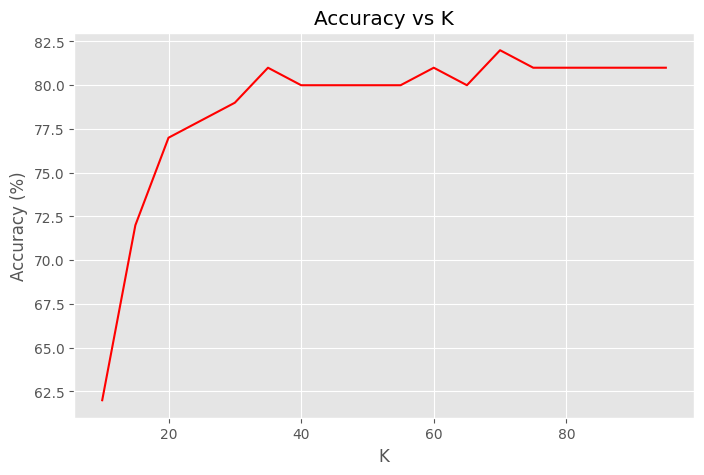

In [247]:
x = [10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95]

plt.figure(figsize=(8,5))
plt.plot(x,results,color='r')
plt.title('Accuracy vs K')
plt.ylabel('Accuracy (%)')
plt.xlabel('K')
plt.show()


## Resizing

In [250]:
defaultDimensions = (227,227)
resizeDimensions = [(24,24),(36,36),(48,48),(60,60),(72,72),(84,84)]
resizeTotalCorrect = 0
resizeResults = []

In [249]:
def resizeTest(img,size,path):
    # Resize image to new size
    img = img.resize(size)
    # Revert to previous size
    img = img.resize(defaultDimensions)
    # Make prediction
    prediction = getResult(predictAnimal(img,alexModel)[0])
    answer = getAnimal(path)
    # Evaluate prediction
    if prediction == answer:
        return 1
    else:
        return 0

In [ ]:
for size in resizeDimensions:
    resizeTotalCorrect = 0
    for path in paths:
        img = Image.open(path)
        resizeTotalCorrect += resizeTest(img,size,path)
    resizeResults.append(resizeTotalCorrect)

In [252]:
print(resizeResults)

[62, 69, 76, 81, 88, 92]


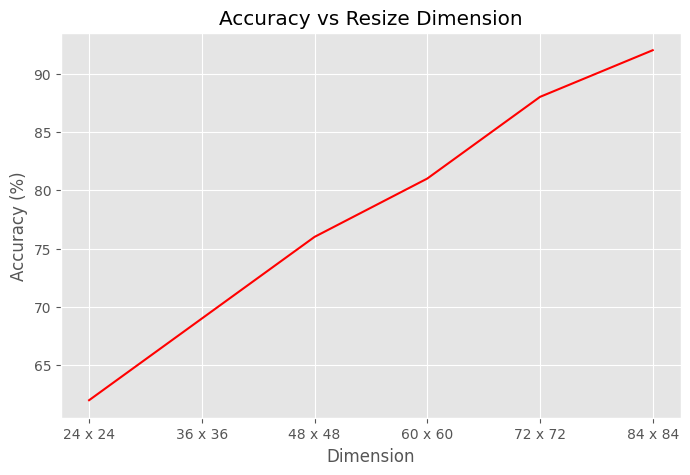

In [253]:
xr = ['24 x 24','36 x 36','48 x 48','60 x 60','72 x 72','84 x 84']

plt.figure(figsize=(8,5))
plt.plot(xr,resizeResults,color='r')
plt.title('Accuracy vs Resize Dimension')
plt.ylabel('Accuracy (%)')
plt.xlabel('Dimension')
plt.show()

## Epsilon

In [231]:
epsilonTotalCorrect = 0
epsilonValues = [100,1000,10000,20000]
epsilonResults = []

In [233]:
import random

def distortImage(img,epsilon):
    x = img.shape[0]   
    for i in range(epsilon):
        p = random.randint(0,x-1)
        q = random.randint(0,x-1 )
        img[p][q][0] = 0
        img[p][q][1] = 0
        img[p][q][2] = 0
    return img

In [ ]:
for epsilon in epsilonValues:
    epsilonTotalCorrect = 0
    for path in paths:
        # Apply distorition to image
        img = Image.open(path).resize((227,227))
        img2 = distortImage(np.copy(img),epsilon)
        # Revert back to original shape
        img2 = img2.reshape(227,227,3)
        # Make predictions
        prediction = getResult(predictAnimal(img2,alexModel)[0])
        answer = getAnimal(path)
        # Evaluate predicitons
        if prediction == answer:
            epsilonTotalCorrect += 1
    epsilonResults.append(epsilonTotalCorrect)


In [237]:
print(epsilonResults)

[94, 94, 74, 59]


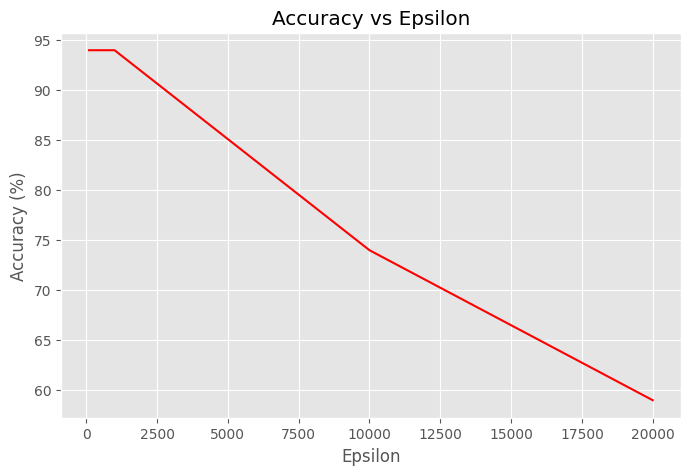

In [238]:
x = [10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95]

plt.figure(figsize=(8,5))
plt.plot(epsilonValues,epsilonResults,color='r')
plt.title('Accuracy vs Epsilon')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epsilon')
plt.show()